# Capstone Project

## Modelling with LSTM

In [1]:
#importing Libraries
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split


import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


# import keras
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Loading the data

In [2]:
df = pd.read_csv('WELFake_Dataset.csv')
df

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
...,...,...,...,...
72129,72129,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0
72130,72130,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1
72131,72131,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0
72132,72132,Trump tussle gives unpopular Mexican leader mu...,MEXICO CITY (Reuters) - Donald Trump’s combati...,0


## Data pre-processing

In [3]:
#Dropping "Unnamed: 0" column
 
df.drop(["Unnamed: 0"], axis=1, inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   71576 non-null  object
 1   text    72095 non-null  object
 2   label   72134 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [5]:
#check for null values
df.isnull().sum()

title    558
text      39
label      0
dtype: int64

In [6]:
# Drop rows with null values
df.dropna(subset=['title', 'text'], inplace=True)

In [7]:
# Combine 'title' and 'text' columns
df['content'] = df['title'] + " " + df['text']

## Text Cleaning

In [8]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re


# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Lowercase
    text = text.lower()
    
    # Expand contractions (e.g., "isn't" -> "is not")
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"'re", " are", text)
    text = re.sub(r"'s", " is", text)
    text = re.sub(r"'d", " would", text)
    text = re.sub(r"'ll", " will", text)
    text = re.sub(r"'t", " not", text)
    text = re.sub(r"'ve", " have", text)
    text = re.sub(r"'m", " am", text)
    
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    
    # Remove special characters and numbers
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\d', '', text)
    
    # Tokenize and remove stopwords, apply lemmatization
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    # Rejoin tokens into a single string
    text = ' '.join(tokens)
    
    return text

# Apply preprocessing
df['content'] = df['content'].apply(preprocess_text)


## Tokenize and Pad Text

In [9]:
# Parameters for tokenization and padding
max_words = 50000  # Vocabulary size
max_len = 300      # Maximum sequence length

# Tokenize the text
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['content'])
sequences = tokenizer.texts_to_sequences(df['content'])

# Pad sequences to ensure uniform input size
X = pad_sequences(sequences, maxlen=max_len)
y = df['label'].values

## Split the Data

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Building and Compiling the LSTM Model


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
embedding_dim = 100  # Embedding vector size

model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim),
    LSTM(128, return_sequences=True),  # Use return_sequences for stacked LSTM
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Binary classification (0=fake, 1=real)
])


# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Train the model

In [12]:
epochs = 5
batch_size = 64

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                    validation_data=(X_test, y_test), verbose=1)

Epoch 1/5
895/895 ━━━━━━━━━━━━━━━━━━━━ 520s 580ms/step - accuracy: 0.8679 - loss: 0.2988 - val_accuracy: 0.9394 - val_loss: 0.1761
Epoch 2/5
895/895 ━━━━━━━━━━━━━━━━━━━━ 497s 556ms/step - accuracy: 0.9658 - loss: 0.1016 - val_accuracy: 0.8414 - val_loss: 0.4050
Epoch 3/5
895/895 ━━━━━━━━━━━━━━━━━━━━ 512s 572ms/step - accuracy: 0.9621 - loss: 0.1085 - val_accuracy: 0.9602 - val_loss: 0.1229
Epoch 4/5
895/895 ━━━━━━━━━━━━━━━━━━━━ 523s 584ms/step - accuracy: 0.9897 - loss: 0.0323 - val_accuracy: 0.9562 - val_loss: 0.1596
Epoch 5/5
895/895 ━━━━━━━━━━━━━━━━━━━━ 500s 559ms/step - accuracy: 0.9962 - loss: 0.0124 - val_accuracy: 0.9636 - val_loss: 0.1717


## Save the model

In [25]:
model.save('trained_lstm_model.keras')


## Evaluation

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predict and evaluate
y_pred = (model.predict(X_test) > 0.5).astype("int32")

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

448/448 ━━━━━━━━━━━━━━━━━━━━ 53s 117ms/step
Accuracy: 0.9635868045848477
Precision: 0.9586867305061559
Recall: 0.9696969696969697
F1 Score: 0.9641604182431038


Text(70.72222222222221, 0.5, 'Real Labels')

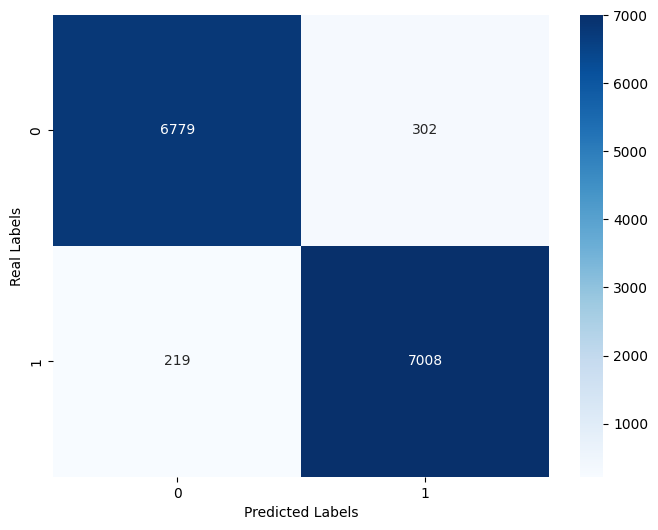

In [14]:
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

plt.figure(figsize = (8,6))

sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, 
            fmt='', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('Real Labels')

## Create a pipeline with preprocessor and LTSM model

In [15]:
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.base import BaseEstimator, TransformerMixin

class Preprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, max_length=300, vocab_size=50000):
        self.max_length = max_length
        self.vocab_size = vocab_size
        self.tokenizer = None

    def clean_text(self, text):
        # Lowercase
        text = text.lower()
        
        # Expand contractions
        text = re.sub(r"n't", " not", text)
        text = re.sub(r"'re", " are", text)
        text = re.sub(r"'s", " is", text)
        text = re.sub(r"'d", " would", text)
        text = re.sub(r"'ll", " will", text)
        text = re.sub(r"'t", " not", text)
        text = re.sub(r"'ve", " have", text)
        text = re.sub(r"'m", " am", text)
        
        # Remove URLs
        text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
        
        # Remove special characters and numbers
        text = re.sub(r'\W', ' ', text)
        text = re.sub(r'\d', '', text)
        
        # Tokenize and remove stopwords, apply lemmatization
        tokens = text.split()
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
        
        # Rejoin tokens into a single string
        text = ' '.join(tokens)
        
        return text

    def fit(self, X, y=None):
        # Clean text for each entry in X
        X_cleaned = [self.clean_text(text) for text in X]
        # Initialize and fit the tokenizer
        self.tokenizer = Tokenizer(num_words=self.vocab_size)
        self.tokenizer.fit_on_texts(X_cleaned)
        return self

    def transform(self, X, y=None):
        # Clean and tokenize text, then pad sequences
        X_cleaned = [self.clean_text(text) for text in X]
        X_tokenized = self.tokenizer.texts_to_sequences(X_cleaned)
        X_padded = pad_sequences(X_tokenized, maxlen=self.max_length)
        return X_padded

In [ ]:
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import load_model


preprocessor = Preprocessor(max_length=300, vocab_size=50000)
preprocessor.fit(df['content']) 

# Load the pre-trained model
loaded_model = load_model('lstm_model.keras')

# Define the pipeline with the loaded model as the classifier
pipe = Pipeline([
    ('preprocessor', preprocessor), 
    ('classifier', loaded_model)     # Loaded pre-trained model as classifier
])

## Testing

In [29]:
fake_news_example = """
BREAKING: Scientists discover that consuming chocolate three times a day will extend lifespan by 30 years!
According to a new report, researchers have found groundbreaking evidence that eating chocolate regularly can
drastically improve life expectancy and prevent almost all diseases. This new "miracle food" is said to be 
the ultimate health solution, and officials are now advising people to include it in their daily diets.
"""
# Example prediction
print(pipe.predict(pd.Series('fake_news_example ')))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
[[0.9871118]]


## Saving the tokenizer

In [30]:
import pickle

# Get the tokenizer from the preprocessor in the pipeline
tokenizer = pipe.named_steps['preprocessor'].tokenizer

# Save the tokenizer
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


## Training vs Validation loss

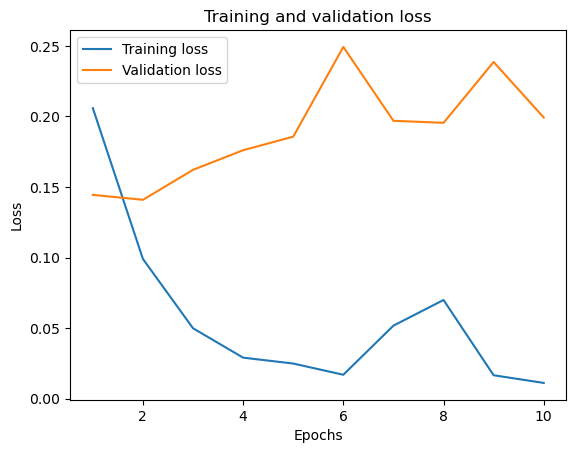

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

## Model Architecture plot

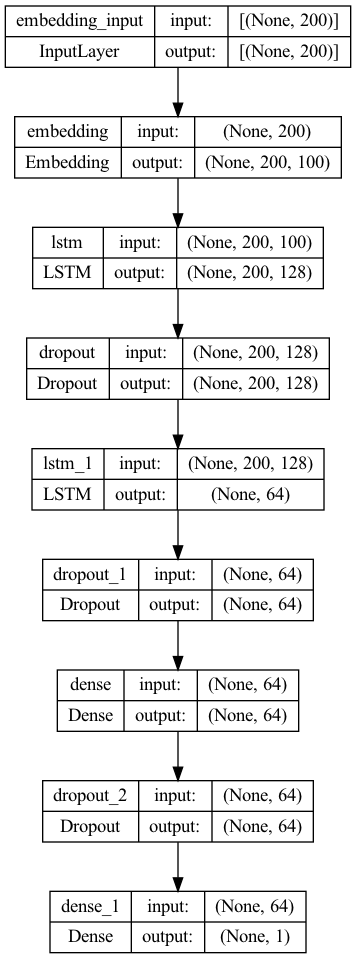

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file="lstm_model.png", show_shapes=True, show_layer_names=True)
